# Graph-convolutional auto-encoder: BlogCatalog

## Imports and setup

In [1]:
import time
import random
import csv
from collections import defaultdict
import os

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

import nw2vec
from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching
from nw2vec import graph

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
MODEL_NAME = 'vae-blogcatalog'

### Model drawing routines

In [3]:
def plot_ξ_distribution(g, q_model, adj, features):
    #g, l, k = glk
    #palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
    #                          .5 * np.ones((l, 1))],
    #                         axis=1)
    #communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                        adj.shape[0], 1,
                                        p=1, q=1, neighbour_samples=None))
    q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

    # KDE plots
    #q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
    #for i in range(l):
    #    x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
    #    y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
    #    sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
    #               shade=True, shade_lowest=False, ax=ax1)
    #ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=25)#, c=palette[communities])
    #sb.kdeplot(q_pred_μ[0], q_pred_μ[1], ax=ax2)
    #for i, (x, y) in enumerate(q_pred_μ.T):
    #    ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    #ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    #ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

## Load data

In [4]:
### Get the full list of nodes and groups ###

crop = None

# nodes
nodes = []
with open('data/BlogCatalog-dataset/data/nodes.csv') as csvfile:
    reader = csv.reader(csvfile)
    nodes = [int(row[0]) for row in reader]
if crop is not None:
    nodes = nodes[:crop]
assert len(nodes) == len(set(nodes))
nodes = set(nodes)

# groups
groups = []
with open('data/BlogCatalog-dataset/data/groups.csv') as csvfile:
    reader = csv.reader(csvfile)
    groups = [int(row[0]) for row in reader]
assert len(groups) == len(set(groups))
groups = set(groups)


### Generate graph from edges and node data ###

# Read edges.csv and make a network out of it
edges = defaultdict(list)
with open('data/BlogCatalog-dataset/data/edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes and int(row[1]) in nodes:
                edges[int(row[0])].append(int(row[1]))
        else:
            edges[int(row[0])].append(int(row[1]))

g = nx.from_dict_of_lists(edges, create_using=nx.Graph())
if crop is not None:
    g.add_nodes_from(nodes)

# Read group-edges.csv and add that info to each node
group_edges = defaultdict(list)
with open('data/BlogCatalog-dataset/data/group-edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes:
                group_edges[int(row[0])].append(int(row[1]))
        else:
            group_edges[int(row[0])].append(int(row[1]))

for node, data in g.nodes.items():
    data['groups'] = group_edges[node]


### Sanity checks ###
assert set(g.nodes) == nodes
#CROP
if crop is None:
    assert set().union(*[groups for _, groups in g.nodes(data='groups')]) == groups

## Set node labels

In [5]:
labels = np.zeros((len(nodes), len(groups)))
nodes_offset = min(nodes)
groups_offset = min(groups)
for n, data in g.nodes.items():
    labels[n - nodes_offset, np.array(data['groups']) - groups_offset] = 1
#labels += np.random.normal(scale=.2, size=labels.shape)

## Load models

In [7]:
#import pickle
#with open('data/benchmarks/blogcatalog/crop=None---n_ξ_samples=5-dims=(39, 10, 2)-bias=False---seeds_per_batch=10-WL=100-p=1-q=1-neighbour_samples=30-n_epochs=10.results.pkl', 'rb') as f:
#    results = pickle.load(f)

In [8]:
checkpoint_filenames = list(filter(lambda s: s.endswith('.h5'), os.listdir('data/benchmarks/blogcatalog')))
#losses = list(map(lambda s: float(s[-9:-3]), checkpoint_filenames))
#best_checkpoint_filename = checkpoint_filenames[np.argmin(losses)]
best_checkpoint_filename = checkpoint_filenames[0]
best_checkpoint_path = 'data/benchmarks/blogcatalog/' + best_checkpoint_filename

In [11]:
# VAE Parameters
n_nodes = len(nodes)
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = len(groups), 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False

q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)
q_model.load_weights(best_checkpoint_path, by_name=True)

vae = keras.models.load_model(best_checkpoint_path,
                              custom_objects=nw2vec.custom_objects())

/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Target function

In [12]:
features = utils.scale_center(labels)

def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(features[final_nodes], 1, n_ξ_samples),
    ]

## Results

In [13]:
#plot_ξ_distribution(g, q_model, adj, labels)

TODO:
- add colors? (which color?)
- transformation ellipses

In [14]:
x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

In [15]:
embedding_codec = codecs.Gaussian(q_pred)

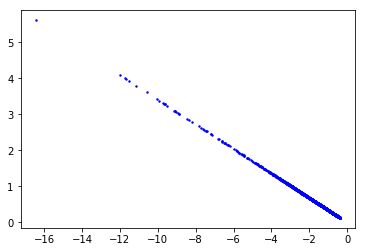

In [26]:
plt.scatter(q_pred[:, 0], q_pred[:, 1], s=2, color='blue')
xlim = plt.xlim()
ylim = plt.ylim()

In [17]:
R = K.eval(embedding_codec.R)

In [18]:
R.min()

-0.010687711

In [19]:
C = R @ R.transpose([0, 2, 1])

In [20]:
from scipy import linalg

In [21]:
evals, evecs = zip(*[linalg.eigh(c) for c in C])
evals = np.array(evals)
evecs = np.array(evecs)

In [22]:
e_widths = 3 * 2 * np.sqrt(evals[:, 0])
e_heights = 3 * 2 * np.sqrt(evals[:, 1])
e_angles = 180 * np.arctan(evecs[:, 0, 1] / evecs[:, 0, 0]) / np.pi

In [23]:
from matplotlib.patches import Ellipse, Circle
from matplotlib.collections import PatchCollection

(-0.14913709728115362, 5.8829708573042705)

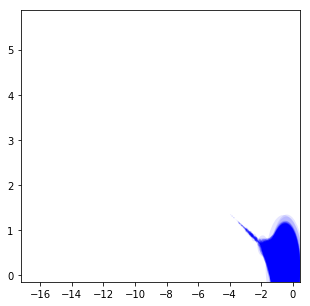

In [29]:
ellipses = PatchCollection([Ellipse(q_pred[i, :2], e_widths[i], e_heights[i], e_angles[i])
                            for i in range(n_nodes)],
                           facecolor='blue', alpha=.1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(ellipses)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

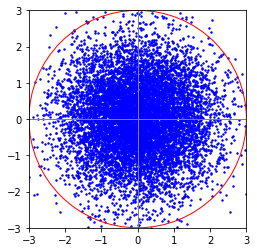

In [30]:
p = np.random.normal(size=(10000, 2))

fig, ax = plt.subplots()
ax.bar(0, 6, 0, -3, lw=1, edgecolor='gray')
ax.barh(0, 6, 0, -3, lw=1, edgecolor='gray')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')

ax.scatter(p[:, 0], p[:, 1], s=2, color='blue')
ax.add_artist(Circle((0, 0), 3 * 1, facecolor='none', edgecolor='red'))

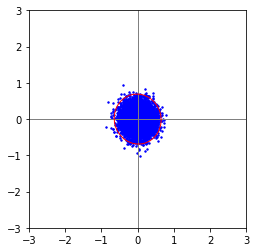

In [31]:
i = 1000
Rp = (R[i] @ p.T).T

fig, ax = plt.subplots()
ax.bar(0, 6, 0, -3, lw=1, edgecolor='gray')
ax.barh(0, 6, 0, -3, lw=1, edgecolor='gray')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')

ax.scatter(Rp[:, 0], Rp[:, 1], s=2, color='blue')
ax.add_artist(Ellipse((0, 0), 3 * 2 * np.sqrt(evals[i, 0]), 3 * 2 * np.sqrt(evals[i, 1]),
                      180 * np.arctan(evecs[i, 0, 1] / evecs[i, 0, 0]) / np.pi,
                      facecolor='none', edgecolor='red'))

Predicted adjacency matrix:

In [32]:
p_input = keras.layers.Input(shape=(2,), name='p_input')
(p_adj, p_v), p_codecs = ae.build_p_builder(dims, use_bias=use_bias)(p_input)

In [33]:
p_model = keras.Model(inputs=p_input, outputs=[p_adj, p_v])
p_model.load_weights(best_checkpoint_path, by_name=True)

In [34]:
adj_preds, v_preds = zip(*[p_model.predict_on_batch(K.eval(embedding_codec.stochastic_value(1))[:, 0, :])
                           for _ in range(10)])

adj_preds = np.array(adj_preds)
v_preds = np.array(v_preds)

adj_pred = scipy.special.expit(adj_preds[:, 0, :, :]).mean(0)
v_pred = v_preds.mean(0)

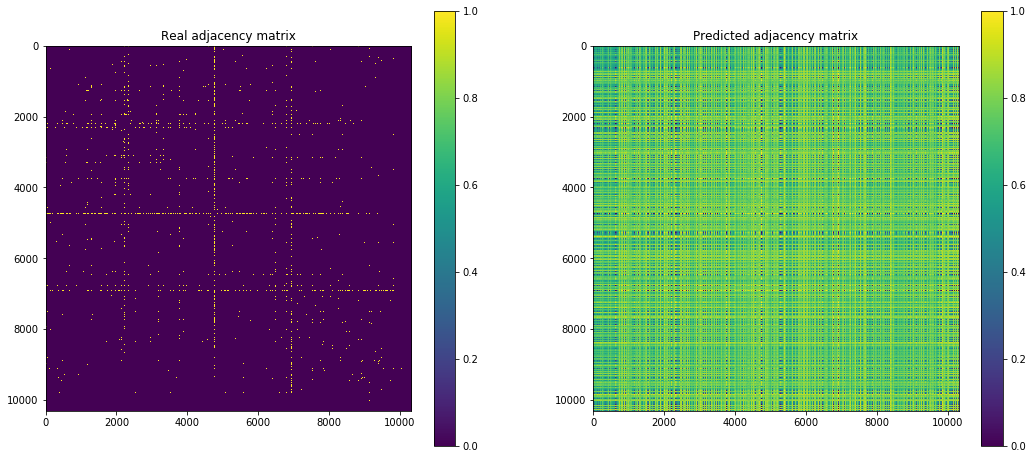

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred)
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

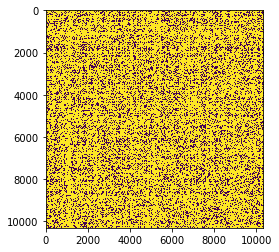

In [36]:
plt.imshow(np.random.binomial(1, adj_pred))

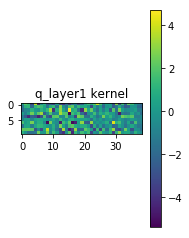

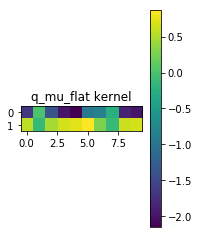

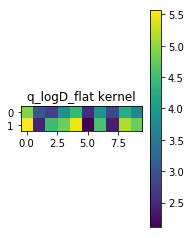

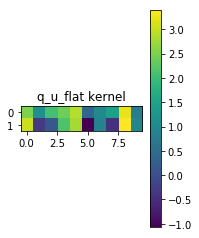

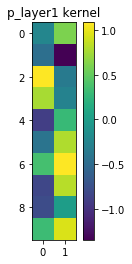

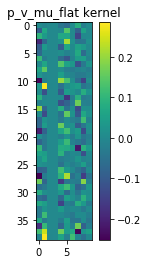

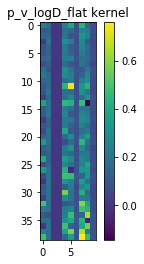

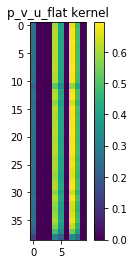

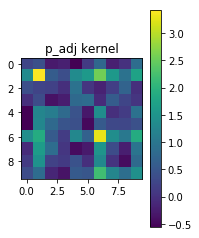

In [37]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)
    else:
        ax2.set_visible(False)